**Importing libraries**

In [1]:
import os
import h5py  # Import the h5py library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import numpy as np,tensorflow as tf
import matplotlib.pyplot as plt
import os,random, cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [3]:
main_dir = os.getcwd()
# Set data directories relative to the main directory
data_dir = os.path.join(main_dir, 'mat_files')
images_dir = os.path.join(main_dir, 'images')
train_images_dir = os.path.join(main_dir, 'train')
test_images_dir = os.path.join(main_dir, 'test')
original_annotation_file_path = os.path.join(main_dir, 'annotations/original_annotations.csv')
output_annotation_file_path = os.path.join(main_dir, 'annotations/output_annotations.csv')
train_annotation_file_path = os.path.join(main_dir, 'annotations/train_annotations.csv')
test_annotation_file_path = os.path.join(main_dir, 'annotations/test_annotations.csv')

## Data Preparation

**Exporting Annotations**

In [4]:
# Create a DataFrame to store annotation information
original_annotations = pd.DataFrame(columns=['filename', 'label', 'tumorBorder'])

# Function to extract the numeric part of the filename for sorting
def extract_number(filename):
    return int(os.path.splitext(filename)[0])

# Get sorted list of .mat files using the custom sort key
mat_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.mat')], key=extract_number)

# Iterate over all .mat files in the dataset directory
for mat_file in mat_files:
    mat_file_path = os.path.join(data_dir, mat_file)
    mat = h5py.File(mat_file_path, 'r')
    cjdata = mat['cjdata']

    # Extract annotation information
    label = int(cjdata['label'][0][0])  # Extract label
    tumor_border = np.array(cjdata['tumorBorder']).flatten().tolist()  # Extract tumor border

    # Create the filename with .jpg extension
    image_filename = f"{os.path.splitext(mat_file)[0]}.jpg"

    # Append annotation information to the DataFrame
    new_row = pd.DataFrame([{
        'filename': image_filename,
        'label': label,
        'tumorBorder': tumor_border
    }])
    original_annotations = pd.concat([original_annotations, new_row], ignore_index=True)

    mat.close()

# Save annotations to a CSV file
original_annotations.to_csv(original_annotation_file_path, index=False)

print("Annotations saved")


Annotations saved


**Dataset Preparation** : Add new bounding box information (xmin, xmax, ymin, ymax) to existing annotations and save them to a new file

In [5]:
# Load annotations
original_annotations = pd.read_csv(original_annotation_file_path)

# Helper function to compute bounding box from tumor border
def get_bounding_box(tumor_border):
    coords = np.array(tumor_border).reshape(-1, 2)
    x_min = np.min(coords[:, 0])
    y_min = np.min(coords[:, 1])
    x_max = np.max(coords[:, 0])
    y_max = np.max(coords[:, 1])
    return x_min, x_max, y_min, y_max

# Initialize a list to store the modified annotations
modified_annotations = []

# Iterate over each row in the annotations DataFrame
for index, row in original_annotations.iterrows():
    filename = row['filename']
    label = row['label']
    tumor_border = eval(row['tumorBorder'])

    # Get the bounding box coordinates
    x_min, x_max, y_min, y_max = get_bounding_box(tumor_border)

    # Append the modified annotation to the list
    modified_annotations.append([filename, x_min, x_max, y_min, y_max, label])

# Create a new DataFrame with the modified annotations
modified_annotations_df = pd.DataFrame(modified_annotations, columns=['filename', 'xmin', 'xmax', 'ymin', 'ymax', 'label'])

# Save the modified annotations to a new CSV file
modified_annotations_df.to_csv(output_annotation_file_path, index=False)

print("Modified annotations saved ")


Modified annotations saved 


In [6]:
modified_annotations_df = pd.read_csv(output_annotation_file_path)
# Count the number of images for each label
label_counts = modified_annotations_df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']
print(label_counts)

# Map labels to their corresponding names
label_mapping = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
label_counts['label'] = label_counts['label'].map(label_mapping)

# Display the result
label_counts

   label  count
0      2   1426
1      3    930
2      1    708


,label,count
0,Glioma,1426
1,Pituitary Tumor,930
2,Meningioma,708


**Split the dataset into train and test sets**

In [7]:
# Split the dataset into train and test sets, stratified by label
train_df_list = []
test_df_list = []

# Group by label
for label, group in modified_annotations_df.groupby('label'):
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_df_list.append(train)
    test_df_list.append(test)

# Concatenate the results
train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

# Save the train and test annotations to CSV files
train_df.to_csv(train_annotation_file_path, index=False)
test_df.to_csv(test_annotation_file_path, index=False)

print("Training annotations saved")
print("Testing annotations saved")


Training annotations saved
Testing annotations saved


In [8]:
# Load train annotations
train_df = pd.read_csv(train_annotation_file_path)

# Label mapping
label_mapping = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}

# Write train.csv to annotation.txt
with open("annotation.txt", "w") as f:
    for idx, row in train_df.iterrows():
        # Construct the full image path
        image_path = os.path.join(train_images_dir, row['filename'])

        # Open the image to get its dimensions
        with Image.open(image_path) as img:
            width, height = img.size

        # Use the correct column names and calculate bounding box coordinates
        x1 = int(row['xmin'])
        x2 = int(row['xmax'])
        y1 = int(row['ymin'])
        y2 = int(row['ymax'])

        fileName = os.path.join(train_images_dir, row['filename'])
        className = label_mapping[row['label']]
        f.write(f"{fileName},{x1},{y1},{x2},{y2},{className}\n")

print("Annotations have been written to annotation.txt")


Annotations have been written to annotation.txt


In [9]:
test_df = pd.read_csv(test_annotation_file_path)

# Label mapping
label_mapping = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}

# Write test.csv to test_annotation.txt
with open("test_annotation.txt", "w") as f:
    for idx, row in test_df.iterrows():
        # Construct the full image path
        image_path = os.path.join(test_images_dir, row['filename'])

        # Open the image to get its dimensions
        with Image.open(image_path) as img:
            width, height = img.size

        # Use the correct column names and calculate bounding box coordinates
        x1 = int(row['xmin'])
        x2 = int(row['xmax'])
        y1 = int(row['ymin'])
        y2 = int(row['ymax'])

        fileName = os.path.join(test_images_dir, row['filename'])
        className = label_mapping[row['label']]
        f.write(f"{fileName},{x1},{y1},{x2},{y2},{className}\n")

print("Test annotations have been written to test_annotation.txt")


Test annotations have been written to test_annotation.txt


In [10]:
# Count the number of images for each label
label_counts_train = train_df['label'].value_counts().reset_index()
label_counts_train.columns = ['label', 'count']
print(label_counts_train)

# Map labels to their corresponding names
label_mapping = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
label_counts_train['label'] = label_counts_train['label'].map(label_mapping)

# Display the result
label_counts_train


   label  count
0      2   1140
1      3    744
2      1    566


,label,count
0,Glioma,1140
1,Pituitary Tumor,744
2,Meningioma,566


In [11]:
# Count the number of images for each label
label_counts_test = test_df['label'].value_counts().reset_index()
label_counts_test.columns = ['label', 'count']
print(label_counts_test)

# Map labels to their corresponding names
label_mapping = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
label_counts_test['label'] = label_counts_test['label'].map(label_mapping)

# Display the result
label_counts_test


   label  count
0      2    286
1      3    186
2      1    142


,label,count
0,Glioma,286
1,Pituitary Tumor,186
2,Meningioma,142


In [12]:
def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.endswith('.jpg')])
    return count

# Count images in train folder
train_image_count = count_images_in_folder(train_images_dir)
print(f"Number of images in train folder: {train_image_count}")

# Count images in test folder
test_image_count = count_images_in_folder(test_images_dir)
print(f"Number of images in test folder: {test_image_count}")


Number of images in train folder: 2450
Number of images in test folder: 614


# Visualizing the Data

In [13]:
# Helper function to plot the image with bounding box and label
def plot_image_with_bbox_and_label(img_path, xmin, xmax, ymin, ymax, label):
    img = Image.open(img_path)

    plt.imshow(img, cmap='gray')
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none', linewidth=2))
    tumor_labels = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
    plt.text(xmin, ymin - 10, tumor_labels[label], color='yellow', fontsize=12, bbox=dict(facecolor='black'))
    plt.show()


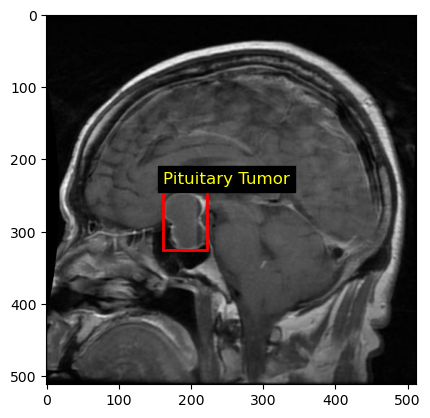

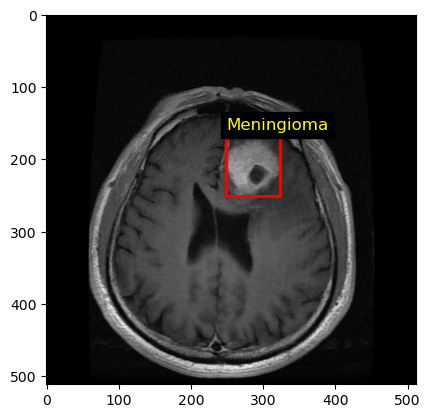

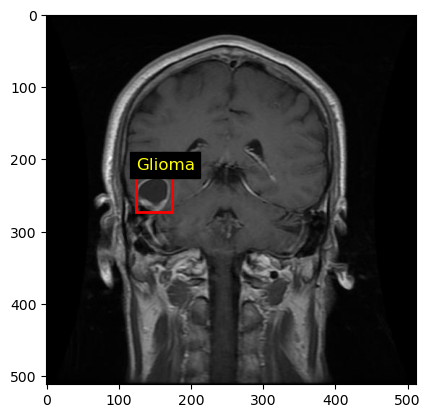

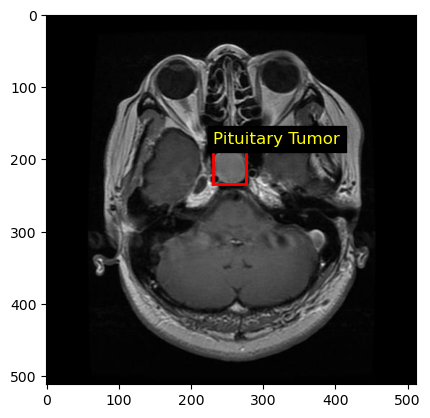

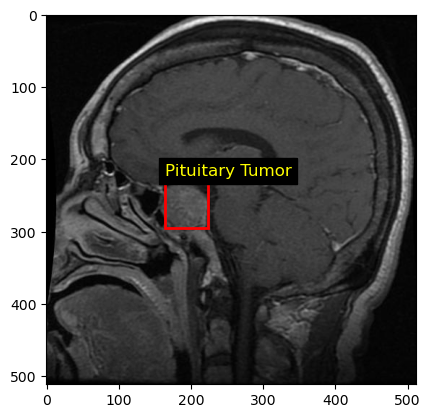

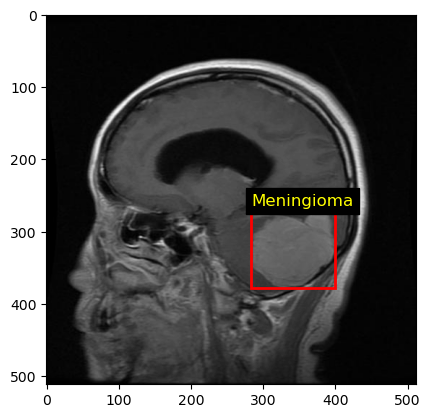

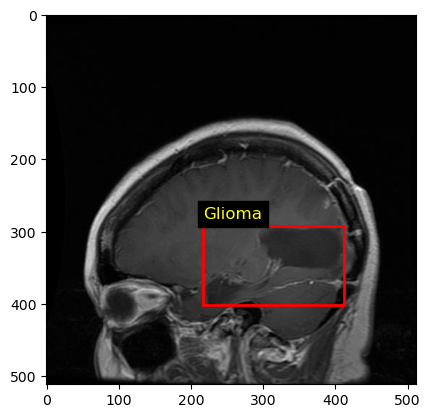

In [14]:
# Load modified annotations
modified_annotations = pd.read_csv(output_annotation_file_path)

# Filenames to plot
filenames = ["1210.jpg","62.jpg", "762.jpg", "1449.jpg","1739.jpg","661.jpg", "3045.jpg"]

# Loop through the filenames and plot each one
for filename in filenames:
    example = modified_annotations[modified_annotations['filename'] == filename].iloc[0]

    # Extract bounding box coordinates and label from the example
    xmin = example['xmin']
    xmax = example['xmax']
    ymin = example['ymin']
    ymax = example['ymax']
    label = example['label']

    # Full path to the image
    img_path = os.path.join(images_dir, filename)

    # Plot the image with bounding box and label
    plot_image_with_bbox_and_label(img_path, xmin, xmax, ymin, ymax, label)
